In [1]:
### THIS IS EXPERIMENTAL AND WILL PROBABLY MALFUNCTION IN UNEXPECTED WAYS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import io
import glob
from PIL import Image
from datetime import datetime
from skimage.exposure import equalize_hist
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.ndimage import median_filter

In [3]:
# Import files from each position
filenames1 = glob.glob('d400_2nd/*glass*detv0*.tif')
filenames2 = glob.glob('d700/*glass*detv0*.tif')
filenames3 = glob.glob('d1000/*glass*detv0*.tif')
# Import 2-theta maps
t1 = io.imread('maps/*d400_2*detv0*_2thetamap.tif')
t2 = io.imread('maps/*d700*detv0*_2thetamap.tif')
t3 = io.imread('maps/*d1000*detv0*_2thetamap.tif')
# Import polarization scaling map
p1 = io.imread('maps/*d400_2*detv0*_polscalemap.tif')
p2 = io.imread('maps/*d700*detv0*_polscalemap.tif')
p3 = io.imread('maps/*d1000*detv0*_polscalemap.tif')

def read_files(filenames):
    data = []
    for i in range(0, len(filenames)):
        data.append(io.imread(filenames[i]))
    data = np.asarray(data)
    
    return data

# Import data at each position
data1 = read_files(filenames1)
data2 = read_files(filenames2)
data3 = read_files(filenames3)

# Set all values less -1 to -1
# -2 seems to indicate dead pixels on pilatus?
data1[data1<=-1] = -1
data2[data2<=-1] = -1
data3[data3<=-1] = -1

# Average all images taken at each position
a1 = np.sum(data1, axis = 0)/data1.shape[0]
a2 = np.sum(data2, axis = 0)/data2.shape[0]
a3 = np.sum(data3, axis = 0)/data3.shape[0]

# Clear data arrays
del data1; del data2; del data3;

# Return a mask with 1 at measured value, NaN at dead pixels or intermodule gaps
def nan_mask(data):
    mask = np.copy(data)
    mask[mask>=0] = 1
    mask[mask<0] = np.nan
    return mask

# Set non-measured pixels to NaN
n1 = np.multiply(a1, nan_mask(a1))
n2 = np.multiply(a2, nan_mask(a2))
n3 = np.multiply(a3, nan_mask(a3))
# Apply polarization scaling correction
n1 = np.divide(n1, p1)
n2 = np.divide(n2, p2)
n3 = np.divide(n3, p3)

In [22]:
def bin_map(tmap, nbins):
    """
    Bin 2-theta map
    Input (2-theta map, total number of bins)
    Return bin, map of bin index
    """
    bins = np.linspace(np.min(tmap), np.max(tmap), num = nbins)
    binned = np.digitize(tmap, bins) -1 # Digitize index starts at 1
    return bins, binned

def unwrap_image(data, datamap, bins = 800):
    """
    Unwraps a 2D diffraction image
    Takes input of diffraction pattern, 2-theta map, and number of bins
        diffraction pattern = data, 2-theta map = datamap, number of bins = bins
    Defaults to 800 bins if no input is provided
    Return bins and unwrapped radial array where rows correspond to each 2-theta bin
    """
    bins, binmap = bin_map(datamap, bins) # Bin input 2-theta map (bins, map of bins)
    values = np.array((binmap.ravel(), data.ravel())) # Values from diffraction pattern (bin, values)
    rind = np.unique(values[0]) # Unique indicies 
    
    avals = [] # Empty array 
    lengths = np.zeros(len(rind)) # Total count of values at each 2-theta
    for i in range (0, len(rind)):
        pos = np.where(values[0] == rind[i])
        vals = np.ndarray.flatten(values[:, pos][1])
        lengths[i] = len(vals)
        avals.append(vals)
   
    radial_array = np.zeros((len(avals), int(np.max(lengths)))) # Output array for unwrapped values
    for i in range (0, len(avals)):
        nan_array = np.empty( int( np.max(lengths) - len(avals[i]) ) ) # Initialize empty array for values not in measurement
        nan_array[:] = np.nan # Set all values in array to NaN
        radial_array[i] = np.concatenate( (avals[i], nan_array) )
    # Return 2-theta bins and unwrapped array
    return bins, radial_array

def normalize(data):
    '''
    Normalize input data (data) by dividing by max value
    Assumes input baseline is already at 0 and doesn't need to be shifted
    '''
    return data/np.max(data)

# def gain_map_all_pos(pos1, pos2, pos3, pos4, pos5, tmap1, tmap2, tmap3, tmap4, tmap5, e_min, e_max, bins = 800):
#     """
#     Calculate a gain map from five positions, return calculated map at each position
#     Input set of average images at three positions (pos1, pos2, pos3) and corresponding 2-theta maps (tmap1, tmap2, tmap3)
#     Provide min/max for 2-theta region to use for extrapolation for high 2-theta (e_min, e_max). This provides an estimated gain at high 2-theta
#     Specify number of bins to use for radial average, defaults to 800
#     Gain map at edges where information is estimated by extrapolation is probably not super reliable
#     Gain map inside beamstop is also not correct
#     """
#     # Unwrap images to generate maps of 2-theta vs number of counts
#     bins1, map1 = unwrap_image(pos1, tmap1, bins)
#     bins2, map2 = unwrap_image(pos2, tmap2, bins)
#     bins3, map3 = unwrap_image(pos3, tmap3, bins)
#     bins4, map4 = unwrap_image(pos4, tmap4, bins)
#     bins5, map5 = unwrap_image(pos5, tmap5, bins)
#     # Get interpolated 1D function corresponding to 1D average of input diffraction patterns
#     ifun1 = interpolate_uwrap(map1, bins1, e_min, e_max)
#     ifun2 = interpolate_uwrap(map2, bins2, e_min, e_max)
#     ifun3 = interpolate_uwrap(map3, bins3, e_min, e_max)
#     ifun4 = interpolate_uwrap(map4, bins4, e_min, e_max)
#     ifun5 = interpolate_uwrap(map5, bins5, e_min, e_max)
    
#     signal = (ifun1(tmap1)+ifun2(tmap1)+ifun3(tmap1)+ifun4(tmap1)+ifun5(tmap1))/5 # Generate 5 estimated signals at position and then average
#     gmap1 = pos1/signal
#     signal = (ifun1(tmap2)+ifun2(tmap2)+ifun3(tmap2)+ifun4(tmap2)+ifun5(tmap2))/5 # Generate 5 estimated signals at position and then average
#     gmap2 = pos2/signal
#     signal = (ifun1(tmap3)+ifun2(tmap3)+ifun3(tmap3)+ifun4(tmap3)+ifun5(tmap3))/5 # Generate 5 estimated signals at position and then average
#     gmap3 = pos3/signal
#     signal = (ifun1(tmap4)+ifun2(tmap4)+ifun3(tmap4)+ifun4(tmap4)+ifun5(tmap4))/5 # Generate 5 estimated signals at position and then average
#     gmap4 = pos4/signal
#     signal = (ifun1(tmap5)+ifun2(tmap5)+ifun3(tmap5)+ifun4(tmap5)+ifun5(tmap5))/5 # Generate 5 estimated signals at position and then average
#     gmap5 = pos5/signal
    
#     return gmap1, gmap2, gmap3, gmap4, gmap5 # Return gainmap

def gain_map_trans(pos1, pos2, pos3, tmap1, tmap2, tmap3, bins = 1500):
    '''
    Calculate a gain map from three positions translated along the beam axis
    Input set of average images at three positions (pos1, pos2, pos3) and corresponding 2-theta maps (tmap1, tmap2, tmap3)
    Specify number of bins to use for radial average, defaults to 1500
    Gain map at edges where information probably not super reliable
    Gain map inside beamstop is also not correct
    '''
    # Unwrap 2D images to give 2-theta positions (tx_n) and intensities (ty_n)
    tx1, ty1 = unwrap_image(pos1, tmap1, bins)
    tx2, ty2 = unwrap_image(pos2, tmap2, bins)
    tx3, ty3 = unwrap_image(pos3, tmap3, bins)

    # Calculate radial median of measured intensity at each 2-theta position
    y1 = np.nanmedian(ty1, axis = 1)
    y2 = np.nanmedian(ty2, axis = 1)
    y3 = np.nanmedian(ty3, axis = 1)

    # Keep max value from normalization of pattern at last position
    # Normalization is performed by assuming baseline is at 0 and dividing by max value seen
    mval = np.max(y3) 
    
    #Interpolate normalized 1D patterns
    f1 = interp1d(tx1, normalize(y1), kind = 'slinear', fill_value = 'extrapolate')
    f2 = interp1d(tx2, normalize(y2), kind = 'slinear', fill_value = 'extrapolate')
    f3 = interp1d(tx3, normalize(y3), kind = 'slinear', fill_value = 'extrapolate')
    
    # Get 1D pattern that corresponds to 2-theta range of last image
    ycomb = np.median((f1(tx3), f2(tx3), f3(tx3)), axis = 0)
    fcomb = interp1d(tx3, ycomb, fill_value = 'extrapolate') # Interpolate median pattern
    # Map combined interpolated pattern to 2-theta map to get idealized signal and un-normalize using stored multiplier
    signal = fcomb(tmap3)*mval
    
    # Calculate gain map
    gmap = signal/pos3
    return gmap # Return gain map

def remove_inf(data):
    '''
    remove nans as well as very large positive or negative numbers created by +/-inf values
    set all nans and infs to zero
    '''
    data = np.nan_to_num(data)
    data[data>10**300] = 0
    data[data<-10**300] = 0
    return data

def damaged_pixels(data):
    '''
    Get gain mask of undamaged and damaged pixels (umap, dmap)
    Define damaged pixels as those with responses more than 4 sigma away from the mean
    Define sigma using 1.4826*MAD
    '''
    median = np.nanmedian(data) # Calculate median
    mad = np.nanmedian(np.abs(data-median)) # Calculate MAD
    sigma = 1.4826*mad # Calculate sigma
    dmap = np.copy(data) # Damaged pixels
    dmap[dmap<(median+4*sigma)] = 0
    umap = np.copy(data) # Undamaged pixels
    umap[umap>(median+4*sigma)] = 0
    return umap, dmap

def map_correction(gainmap, window_size):
    '''
    Corrects gain map containing damaged pixels
    needs median_filter from scipy.ndimage
    '''
    udmap, damap = damaged_pixels(gainmap) # Get map of undamaged and damaged pixels
    filtered = median_filter(gainmap, window_size) # Apply 3x3 median filter to undamaged pixel map
    return filtered+damap # Add back in gains for damaged pixels

In [5]:
tx1, ty1 = unwrap_image(n1, t1, bins = 1500)
tx2, ty2 = unwrap_image(n2, t2, bins = 1500)
tx3, ty3 = unwrap_image(n3, t3, bins = 1500)
y1 = np.nanmedian(ty1, axis = 1)
y2 = np.nanmedian(ty2, axis = 1)
y3 = np.nanmedian(ty3, axis = 1)

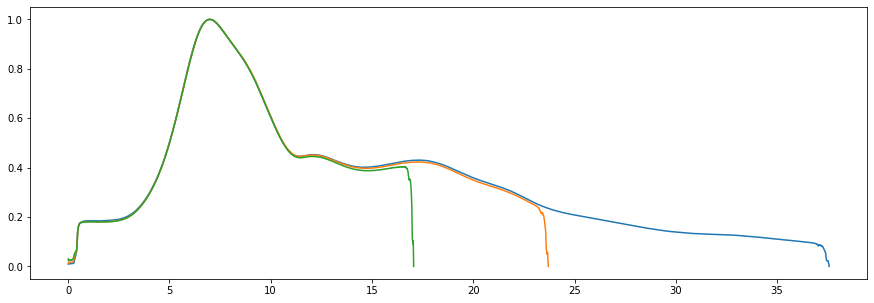

In [6]:
plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(tx1, normalize(y1))
plt.plot(tx2, normalize(y2))
plt.plot(tx3, normalize(y3))

C:\Users\jmswe\AppData\Local\Temp/ipykernel_15688/725889153.py:115: RuntimeWarning: divide by zero encountered in true_divide
  gmap = signal/pos3


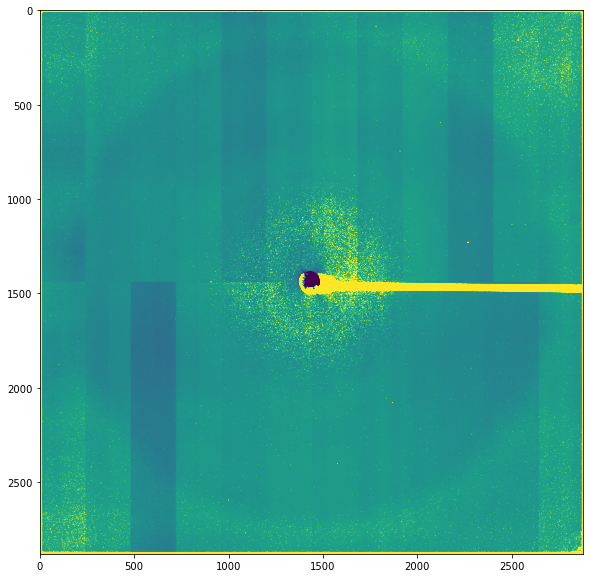

In [23]:
# Calculate gain map
gmap = remove_inf(gain_map_trans(n1, n2, n3, t1, t2, t3))
# Apply median filter using 7x7 median filter
corrmap = map_correction(gmap, 7)
# Show gain map
plt.rcParams["figure.figsize"] = (10, 10)
plt.imshow(corrmap, vmin = 0.85, vmax = 1.15)

In [ ]:
# Export calculated gain map
gainmapfilename = 'Calculated gain map'
# Define gain map format
g_form = 1 # Set to 1 if the gain map is to be multiplied by measured images, 0 if it is to be divided

# Change to whatever format and then remove any nans which may be present
if g_form == 1:
    nmap = np.nan_to_num(corrmap)
if g_form == 0:
    nmap = np.nan_to_num(1/corrmap)
else:
    nmap = np.nan_to_num(corrmap) # Format parameter to something other than 0 returns a multiplied map
# Remove any inf/very large values created by any divide by zeros
nmap[nmap>10**10] = 0
nmap[nmap<-10**10] = 0

# Export map as 32 bit tif
im = Image.fromarray(np.float32(nmap), mode='F') # float32
im.save(gainmapfilename+'_'+datetime.today().strftime('%Y-%m-%d')+'.tif', 'TIFF')